# Projeto de ICD - Dota 2

#### Alunos:
    Gabriel Henrique
    Matheus Vargas
    Raydan Gaspar

1. Definir Tema e grupo. (2pts) ✔️
2. Discussão com Monitores. (3pts) ✔️
3. Relatório Final. Entregue um relatório sobre os resultados que você levantou para responder às suas perguntas. Sua análise dos dados devem apresentar:
    * Uma caracterização (análise exploratória) inicial dos dados (2pts)
    * Pelo menos, dois testes de hipótese/intervalos de confiança (2pts)
        * Os ICs podem ser apresentados nos resultados de regressão e classificação abaixo.
        * Os testes de hipótese também podem ser utilizados abaixo para comparar modelos.
    * Pelo menos uma regressão (3pts)
    * Pelo menos um algoritmo de aprendizado/classificação (3pts)
4. No seu relatório, você deve apresentar pelo menos os seguintes pontos:
 * Introdução com Motivação e Pergunta de Pesquisa
 * Metodologia
 * Descreva sua base
 * Quais métodos e modelos foram utilizados. Justifique os mesmos.
5. Resultados. Sugiro separar em
 * Caracterização (análise exploratória)
     * Testes de hipótese podem vir aqui.
 * Previsão (uma ou duas sub-seções dependendo dos modelos utilizados)
6. Conclusões
 * Responda sua pergunta pelo menos de forma evidencial.
7. Vídeo no Youtube 5 minutos. Pode ser um vídeo só dos slides!! Com as falas, claro. 5pts.

# Introdução


## Motivação

## Pergunta de Pesquisa

# Metodologia


# Descrição da base


# Métodos e modelos utilizados. 
Justifique os mesmos.

# Resultados


### Caracterização (análise exploratória)

### Testes de hipótese podem vir aqui.

### Previsão (uma ou duas sub-seções dependendo dos modelos utilizados)


# Conclusões
Responda sua pergunta pelo menos de forma evidencial.

# Vídeo no Youtube 5 minutos

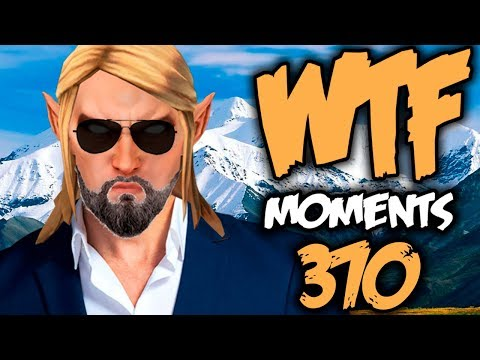

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo('2bCCk0xpurE')

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import io
import sqlite3

In [7]:
conn = sqlite3.connect('dota2_791_partidas.db')
cursor = conn.cursor()

In [12]:
df_obs = pd.read_sql_query(
'''
SELECT x_pos x, y_pos y, sum(obs_count) count 
FROM obs 
GROUP BY x_pos, y_pos 
ORDER BY count DESC 
''', conn)

# df_obs['count'] /= df_obs['count'].mean()
print(df_obs)

        x    y  count
0     112  130    914
1     148  106    733
2     110  146    623
3     148  104    508
4     114   92    478
5     140  106    414
6     144  118    392
7     158  100    276
8     114   94    247
9     158  102    247
10    100  142    227
11    110  130    223
12    110  148    223
13    136  162    223
14    120  136    207
15    136  164    196
16    168  134    193
17    124  130    170
18    126  142    142
19    162  116    139
20    100  144    138
21    164  116    138
22    140   90    136
23    130  106    133
24     90  124    130
25    134  164    121
26     90  160    119
27    170  134    114
28     92  160    113
29    162  118    108
...   ...  ...    ...
1109  174   98      1
1110  174  106      1
1111  174  120      1
1112  174  140      1
1113  174  154      1
1114  174  170      1
1115  174  174      1
1116  176  108      1
1117  176  116      1
1118  176  118      1
1119  176  146      1
1120  176  152      1
1121  176  162      1
1122  176 

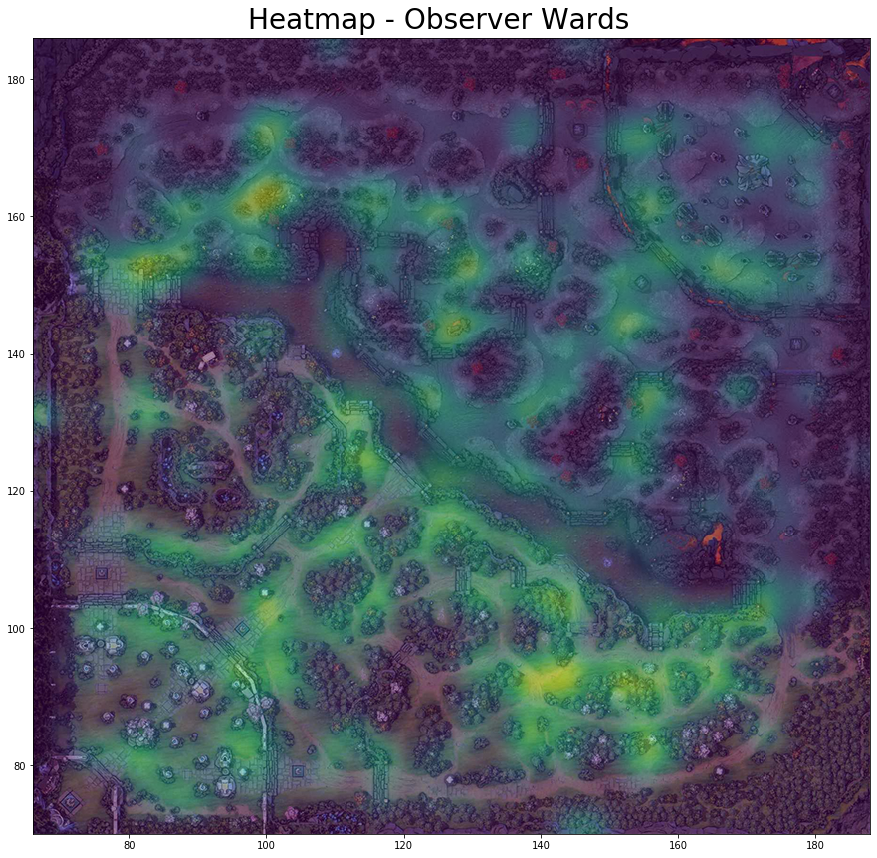

In [13]:
img = plt.imread("Minimap_6.88.jpg")

fig, ax = plt.subplots(figsize=(15,15))
fig.suptitle('Heatmap - Observer Wards', fontsize=28, y =0.9)

ax.imshow(img, extent=[df_obs['x'].min(), df_obs['x'].max(), df_obs['y'].min(), df_obs['y'].max()])
heatmap, xedges, yedges = np.histogram2d(df_obs['x'], df_obs['y'], bins=35)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

ax.imshow(heatmap.T, extent=extent, origin='lower', alpha=0.5, interpolation='bicubic')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf077abcc0>]],
      dtype=object)

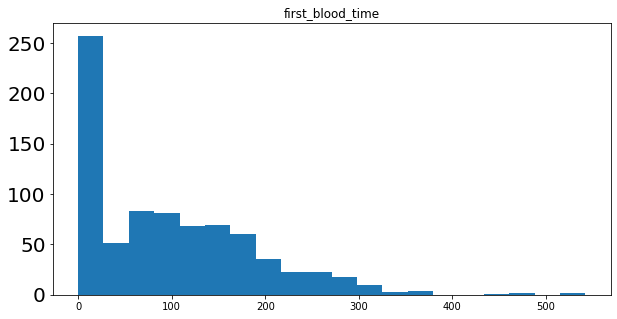

In [28]:
df_first_blood = pd.read_sql_query(
'''
SELECT first_blood_time
FROM match
ORDER BY first_blood_time DESC
''', conn)

#print(df_first_blood)
df_first_blood.hist(bins=20, grid=False, ylabelsize=20, xlabelsize=10, figsize = (10,5))